# Make Heatmap Plots of Sensitivity Analysis Results

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from platform import python_version

python_version()

'3.9.12'

In [2]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = "Times New Roman"
plt.rcParams['mathtext.it'] = "Times New Roman:italic"
plt.rcParams['mathtext.bf'] = "Times New Roman:bold"

In [3]:
#sys_name = 'P2Dcd1_T'   # identified from true system
sys_name = 'P2DcTd4'  # id. from data and used in report
plot_dir = 'plots'
results_dir = f'results/sens/{sys_name}'
results_dir

'results/sens/P2DcTd4'

In [4]:
os.listdir(results_dir)

['rod_obs_sim_2_6.csv',
 'rod_obs_sim_1_6.csv',
 'rod_obs_sim_sens_1_summary.csv',
 'rod_obs_sim_sens_2_summary.csv']

## Function to plot heatmap

In [5]:
from plot_utils import make_sensitivity_heatmap

## Sensitivity to process model parameters

Note: Because the model was initially specified as a continuous time model with parameters Kp Tp1 and d, and then converted to discrete time, the parameters are not included in the results file.

In [6]:
filename= 'rod_obs_sim_sens_1_summary.csv'

summary_results = pd.read_csv(os.path.join(results_dir, filename))
summary_results.shape

(49, 1220)

In [7]:
var_names = ['Kp', 'Tp1']  # static gain and time constant
var_unique_values = pd.DataFrame({col: summary_results[col].unique() for col in var_names})
n_vars = len(var_unique_values)
var_unique_values

,Kp,Tp1
0,-16.200000,0.053000
1,-21.600000,0.070667
2,-28.173913,0.092174
3,-32.400000,0.106000
4,-37.260000,0.121900
5,-48.600000,0.159000
6,-64.800000,0.212000


In [8]:
centre_points = var_unique_values.iloc[n_vars // 2].to_dict()
if sys_name == 'P2DcTd4':
    assert(centre_points == {'Kp': -32.4, 'Tp1': 0.106})
elif sys_name == 'P2Dcd1_T':
    assert(centre_points == {'Kp': -35.935, 'Tp1': 0.23503})
centre_points

{'Kp': -32.4, 'Tp1': 0.106}

In [9]:
summary_results.head()

,Time,Kp,Tp1,p_case,i_in_seq,t_stop,Ts,nT,nu,ny,...,RMSE_y_est_MKF_SP,RMSE_tr_y_est_MKF_SP,RMSE_ss_y_est_MKF_SP,Var_ss_y_est_MKF_SP,RMSD_ss_y_est_MKF_SP,RMSE_y_est_SKF,RMSE_tr_y_est_SKF,RMSE_ss_y_est_SKF,Var_ss_y_est_SKF,RMSD_ss_y_est_SKF
0,2022-12-10 21:20,-16.200000,0.053,1,6,123,0.05,2460,0,1,...,1.709439,2.630852,1.246978,0.744560,0.417761,1.452646,2.032801,1.191166,0.574288,0.315723
1,2022-12-10 21:21,-21.600000,0.053,1,6,123,0.05,2460,0,1,...,1.726083,2.533896,1.342714,0.985201,0.520701,1.468984,1.966286,1.254538,0.747852,0.401437
2,2022-12-10 21:21,-28.173913,0.053,1,6,123,0.05,2460,0,1,...,1.755116,2.443608,1.446424,1.277320,0.627371,1.535754,1.979379,1.351080,0.994444,0.500956
3,2022-12-10 21:21,-32.400000,0.053,1,6,123,0.05,2460,0,1,...,1.778456,2.402349,1.507039,1.429700,0.692059,1.586353,2.006010,1.414609,1.162543,0.562493
4,2022-12-10 21:21,-37.260000,0.053,1,6,123,0.05,2460,0,1,...,1.806440,2.357289,1.574517,1.627257,0.763825,1.645663,2.042188,1.486027,1.360096,0.631189


In [10]:
xlabel = "% change in time constant ($T_{p1}$)"
ylabel = "% change in static gain ($K_p$)"
minmax = (-0.5, 0.5)

In [11]:
A_matrix_labels = [f'sys_A_{i+1}_{j+1}' for j in range(4) for i in range(4)]
C_matrix_labels = [f'sys_C_{j+1}' for j in range(4)]
sys_matrices = np.unique(summary_results[A_matrix_labels + C_matrix_labels].to_numpy(), axis=0)
print(sys_matrices.shape)
assert(sys_matrices.shape[0] == summary_results.shape[0])

(49, 20)


In [12]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [13]:
obs_label = 'MKF_SF1'
metric_labels = ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 
           'Var_ss_y_est', 'RMSD_ss_y_est']
labels = [f'{metric_label}_{obs_label}' for metric_label in metric_labels]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 5)

In [14]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 35)

In [15]:
sensitivity_data[f'RMSE_y_est_{obs_label}']

Tp1,0.053000,0.070667,0.092174,0.106000,0.121900,0.159000,0.212000
Kp,,,,,,,
-64.800000,1.985512,1.984349,1.975704,1.970169,1.990308,1.977124,1.943974
-48.600000,1.883655,1.879713,1.875231,1.872512,1.887081,1.881465,1.900530
-37.260000,1.811437,1.808799,1.806118,1.819028,1.815210,1.813581,1.832532
-32.400000,1.781046,1.779091,1.776714,1.787739,1.784585,1.784123,1.803408
-28.173913,1.755340,1.754024,1.761712,1.761347,1.758493,1.758750,1.778678
-21.600000,1.722697,1.728540,1.727827,1.727050,1.724403,1.754782,1.746588
-16.200000,1.724255,1.728163,1.727240,1.726190,1.740923,1.744886,1.745731


## Make all heatmaps for selected observer

In [16]:
obs_label

'MKF_SF1'

RMSE_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF1_RMSE_y_est.png


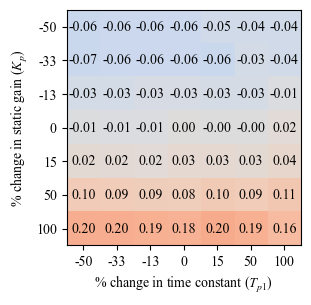

RMSE_tr_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF1_RMSE_tr_y_est.png


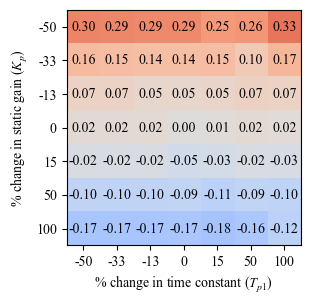

RMSE_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF1_RMSE_ss_y_est.png


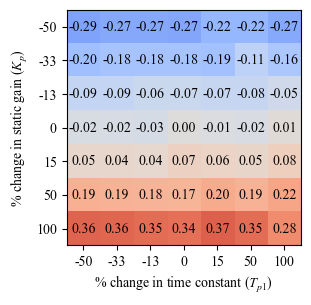

Var_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF1_Var_ss_y_est.png


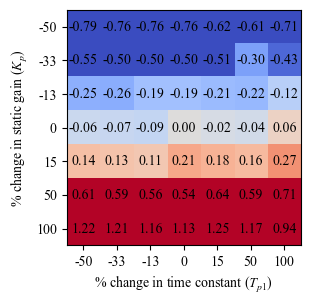

RMSD_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF1_RMSD_ss_y_est.png


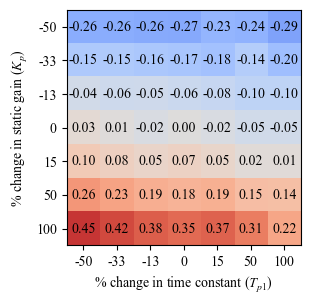

In [17]:
for metric_label in metric_labels:
    data = sensitivity_data[f'{metric_label}_{obs_label}']
    centre_point = tuple(centre_points.values())
    print(metric_label)
    plt.figure(figsize=(3.21, 3.15))
    make_sensitivity_heatmap(data, centre_point, xlabel, ylabel,
                             transform='diff', minmax=[-0.5, 0.5], fmt='{:.2f}')
    plt.tight_layout()
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.pdf'
    plt.savefig(os.path.join(plot_dir, filename))
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.png'
    plt.savefig(os.path.join(plot_dir, filename), dpi=300)
    print(f"Saved to: {filename}")
    plt.show()

## Make heatmaps for selected observers

In [18]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [19]:
obs_labels_select = ['MKF_SF95', 'MKF_SF1', 'MKF_SP', 'KF3']
# ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 'Var_ss_y_est', 'RMSD_ss_y_est']
metric_label = 'RMSE_y_est'

labels = [f'{metric_label}_{obs_label}' for obs_label in obs_labels_select]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 4)

In [20]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 28)

RMSE_y_est
Saved to: rod_obs_sim_sens_sys_4obs_RMSE_y_est.pdf


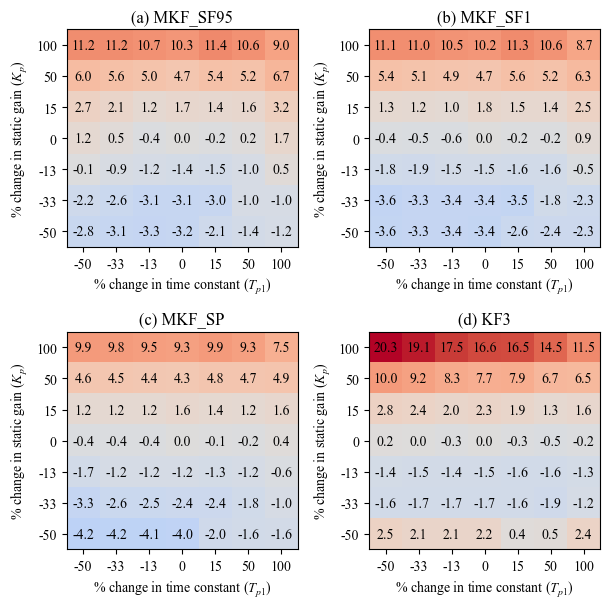

In [21]:
print(metric_label)
fig, axes = plt.subplots(2, 2, figsize=(6.2, 6.2))

if len(obs_labels_select) < 4:
    axes[1, 1].remove()

c = 'a'
for obs_label, ax in zip(obs_labels_select, axes.flatten()):
    data = sensitivity_data[f'{metric_label}_{obs_label}']
    centre_point = tuple(centre_points.values())
    make_sensitivity_heatmap(
        data, centre_point, xlabel, ylabel, ax=ax, 
        title=f"({c}) {obs_label}",
        transform='pct', minmax=[-20, 20], fmt='{:.1f}',
        reverse_y=False
    )
    # Increment index letter
    c = chr(ord(c) + 1)

plt.tight_layout()
filename = f'rod_obs_sim_sens_sys_4obs_{metric_label}.pdf'
plt.savefig(os.path.join(plot_dir, filename))
print(f"Saved to: {filename}")
filename = f'rod_obs_sim_sens_sys_4obs_{metric_label}.png'
plt.savefig(os.path.join(plot_dir, filename), dpi=300)
plt.show()

## Sensitivity to RODD parameters

In [22]:
filename= 'rod_obs_sim_sens_2_summary.csv'

summary_results = pd.read_csv(os.path.join(results_dir, filename))
summary_results.shape

(49, 1218)

In [23]:
var_names = ['epsilon', 'sigma_wp_1_2']  # RODD model parameters
var_unique_values = pd.DataFrame({col: summary_results[col].unique() for col in var_names})
n_vars = len(var_unique_values)
var_unique_values

,epsilon,sigma_wp_1_2
0,0.005000,0.135850
1,0.006667,0.181133
2,0.008696,0.236261
3,0.010000,0.271700
4,0.011500,0.312455
5,0.015000,0.407550
6,0.020000,0.543400


In [24]:
centre_points = var_unique_values.iloc[n_vars // 2].to_dict()
if sys_name == 'P2DcTd4':
    assert(centre_points == {'epsilon': 0.01, 'sigma_wp_1_2': 0.2717})
elif sys_name == 'P2Dcd1_T':
    assert(centre_points == {'epsilon': 0.01, 'sigma_wp_1_2': 0.2717})
centre_points

{'epsilon': 0.01, 'sigma_wp_1_2': 0.2717}

In [25]:
summary_results.head()

,Time,p_case,i_in_seq,t_stop,Ts,nT,nu,ny,n_obs,sys_A_1_1,...,RMSE_y_est_MKF_SP,RMSE_tr_y_est_MKF_SP,RMSE_ss_y_est_MKF_SP,Var_ss_y_est_MKF_SP,RMSD_ss_y_est_MKF_SP,RMSE_y_est_SKF,RMSE_tr_y_est_SKF,RMSE_ss_y_est_SKF,Var_ss_y_est_SKF,RMSD_ss_y_est_SKF
0,10-Dec-2022 21:34:44,2,6,123,0.05,2460,0,1,6,2.247884,...,1.790772,2.503045,1.470130,1.296923,0.577604,1.598362,1.973873,1.447813,1.25207,0.56131
1,10-Dec-2022 21:35:01,2,6,123,0.05,2460,0,1,6,2.247884,...,1.785851,2.477171,1.477064,1.318453,0.585981,1.598362,1.973873,1.447813,1.25207,0.56131
2,10-Dec-2022 21:35:17,2,6,123,0.05,2460,0,1,6,2.247884,...,1.779644,2.449198,1.482947,1.338749,0.595313,1.598362,1.973873,1.447813,1.25207,0.56131
3,10-Dec-2022 21:35:34,2,6,123,0.05,2460,0,1,6,2.247884,...,1.777726,2.435067,1.487808,1.353778,0.600911,1.598362,1.973873,1.447813,1.25207,0.56131
4,10-Dec-2022 21:35:50,2,6,123,0.05,2460,0,1,6,2.247884,...,1.776050,2.420668,1.493145,1.370299,0.606995,1.598362,1.973873,1.447813,1.25207,0.56131


In [26]:
obs_label = 'MKF_SF95'
xlabel = "% change in $\sigma_{w_p}$"
ylabel = "% change in $\epsilon$"
minmax = (-0.5, 0.5)

In [27]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [28]:
metric_labels = ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 
           'Var_ss_y_est', 'RMSD_ss_y_est']
labels = [f'{metric_label}_{obs_label}' for metric_label in metric_labels]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 5)

In [29]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 35)

In [30]:
sensitivity_data[f'RMSE_y_est_{obs_label}']

sigma_wp_1_2,0.135850,0.181133,0.236261,0.271700,0.312455,0.407550,0.543400
epsilon,,,,,,,
0.005000,1.773528,1.765047,1.762727,1.763755,1.766192,1.773930,1.785089
0.006667,1.769691,1.762211,1.761563,1.763588,1.767035,1.776678,1.789705
0.008696,1.766847,1.760972,1.762525,1.765814,1.770531,1.782499,1.797629
0.010000,1.765738,1.761005,1.764006,1.768115,1.773651,1.787090,1.803495
0.011500,1.764959,1.761591,1.766261,1.771307,1.777776,1.792877,1.810691
0.015000,1.764546,1.764428,1.772931,1.780114,1.788708,1.807547,1.828474
0.020000,1.765915,1.770334,1.784040,1.794120,1.805591,1.829461,1.854571


## Make all heatmaps for selected observer

RMSE_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSE_y_est.png


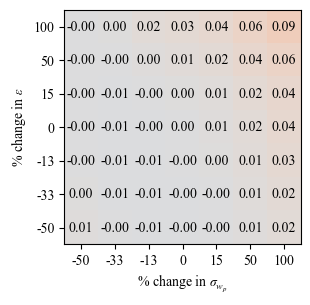

RMSE_tr_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSE_tr_y_est.png


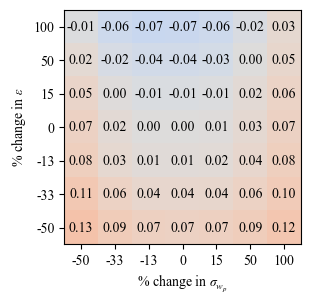

RMSE_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSE_ss_y_est.png


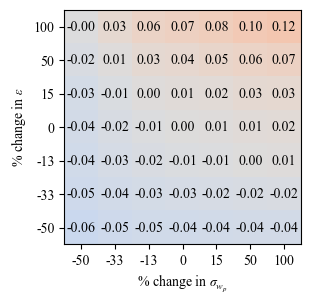

Var_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_Var_ss_y_est.png


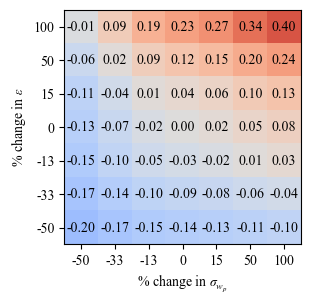

RMSD_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSD_ss_y_est.png


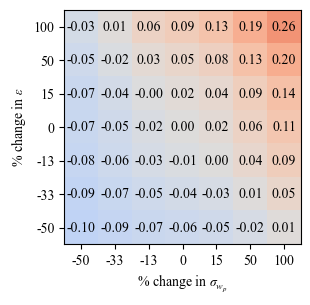

In [31]:
for metric_label in metric_labels:
    data = sensitivity_data[f'{metric_label}_{obs_label}']
    centre_point = tuple(centre_points.values())
    print(metric_label)
    plt.figure(figsize=(3.21, 3.15))
    make_sensitivity_heatmap(data, centre_point, xlabel, ylabel,
                             transform='diff', minmax=[-0.5, 0.5], fmt='{:.2f}')
    plt.tight_layout()
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.pdf'
    plt.savefig(os.path.join(plot_dir, filename))
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.png'
    plt.savefig(os.path.join(plot_dir, filename), dpi=300)
    print(f"Saved to: {filename}")
    plt.show()

## Make heatmaps for selected observers

In [32]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [33]:
obs_labels_select = ['MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']
# ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 'Var_ss_y_est', 'RMSD_ss_y_est']
metric_label = 'RMSE_y_est'

labels = [f'{metric_label}_{obs_label}' for obs_label in obs_labels_select]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 4)

In [34]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 28)

RMSE_y_est
Saved to: rod_obs_sim_sens_rod_4obs_RMSE_y_est.pdf


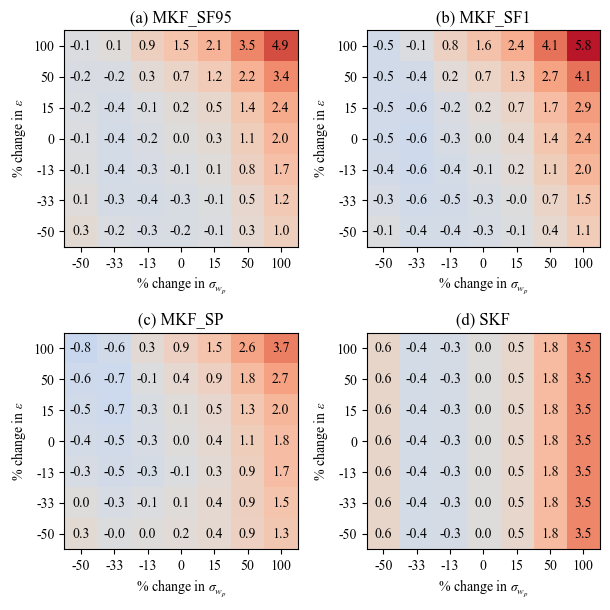

In [35]:
print(metric_label)
fig, axes = plt.subplots(2, 2, figsize=(6.2, 6.2))

if len(obs_labels_select) == 3:
    axes[1, 1].remove()

c = 'a'
for obs_label, ax in zip(obs_labels_select, axes.flatten()):
    data = sensitivity_data[f'{metric_label}_{obs_label}']
    centre_point = tuple(centre_points.values())
    make_sensitivity_heatmap(
        data, centre_point, xlabel, ylabel, ax=ax, 
        title=f"({c}) {obs_label}",
        transform='pct', minmax=[-6, 6], fmt='{:.1f}',
        reverse_y=True
    )
    # Increment index letter
    c = chr(ord(c) + 1)

plt.tight_layout()
filename = f'rod_obs_sim_sens_rod_4obs_{metric_label}.pdf'
plt.savefig(os.path.join(plot_dir, filename))
print(f"Saved to: {filename}")
filename = f'rod_obs_sim_sens_rod_4obs_{metric_label}.png'
plt.savefig(os.path.join(plot_dir, filename), dpi=300)
plt.show()